# X. just trying to make it from scratch

## X.0 Plotting Function

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import numpy as np
         
    
def show_images(image_batch, channel = None, columns = 10) : 
    """
    image_batch : TensorlistCPU (batch of images)
    channel : which channel to see (CDHW라는 가정)
    
    """
    if type(image_batch) == tuple : 
        raise ValueError(f"you are passing in {type(image_batch)} instead of tuple type... maybe do [0] or sth data/label이 같이있냐 data만 있냐에 따라그 조금 다를수도 ")
    image_npy = image_batch.as_array()
    rows = 3 #three slices (axial, and so on)
    plot_scale = 2
    fig = plt.figure(figsize = (columns*plot_scale, rows*plot_scale))
    gs = gridspec.GridSpec(rows,columns)
    for i in range(rows) : 
        for j in range(columns):
            plt.subplot(gs[i,j])
            plt.axis('off')
            
            if channel == None : 
                jth_npy = image_npy[j]
            else : 
                jth_npy = image_npy[j][channel]
            plt.imshow(jth_npy.take(indices = int(jth_npy.shape[i]/2), axis = i)) ##this line is key (fetches the data)
    plt.show()

In [2]:
def show_first_images(image_batch, channel = None, columns = 10) : 
    """
    image_batch : TensorlistCPU (batch of images)
    channel : which channel to see (CDHW라는 가정)
    
    """
    if type(image_batch) == tuple : 
        raise ValueError(f"you are passing in {type(image_batch)} instead of tuple type... maybe do [0] or sth data/label이 같이있냐 data만 있냐에 따라그 조금 다를수도 ")
    image_npy = image_batch.as_array()
    rows = 1 #three slices (axial, and so on)
    plot_scale = 2
    fig = plt.figure(figsize = (columns*plot_scale, rows*plot_scale))
    gs = gridspec.GridSpec(rows,columns)
    for i in range(rows) : 
        for j in range(columns):
            plt.subplot(gs[i,j])
            plt.axis('off')
            
            if channel == None : 
                jth_npy = image_npy[j]
            else : 
                jth_npy = image_npy[j][channel]
            plt.imshow(jth_npy.take(indices = int(jth_npy.shape[i]/2), axis = i)) ##this line is key (fetches the data)


            

#plt.imshow(images[0][0])
#type(images[0].as_array())

## X.1. Trying just loading 

In [12]:
##trying to just do regular stuff
from nvidia.dali.pipeline import Pipeline
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali"

@pipeline_def
def simple_pipeline():
    img = fn.readers.numpy(file_root = data_path)
    #img = fn.reshape(img, layout = "DHW") #CDHW 하면 애러뜸!
    return img #, fn.get_property(img, key = "source_info")


In [4]:
pipe = simple_pipeline(batch_size = 16, num_threads = 1, device_id = 0, seed = 42)
pipe.build()

simple_images = pipe.run()

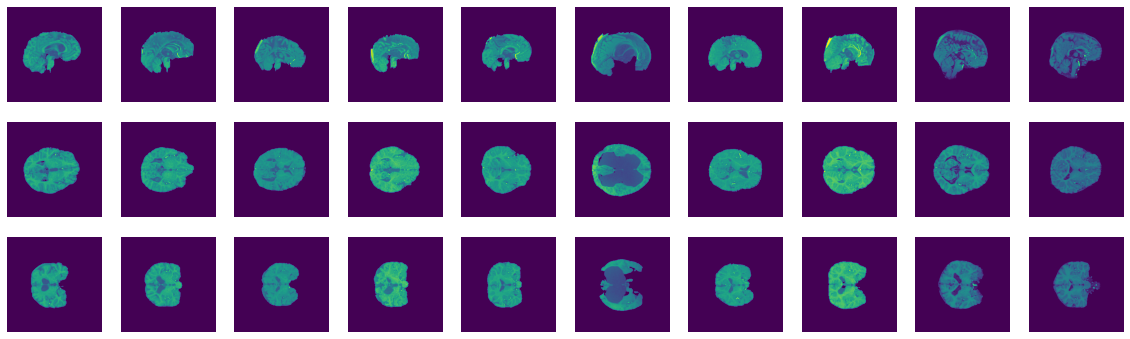

In [5]:
#test
show_images(simple_images[0])

## X.2. Trying Complex Augmentations

In [7]:
##trying to just do regular stuff
from nvidia.dali.pipeline import Pipeline
from nvidia import dali
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali"

def random_augmentation(probability, augmented, original):
    """
    * probability : prob of returning augmented (instead of original)
    * augmented : augmented image (fn거친 것)
    * original : original image (before going through augmented thing)
    """
    condition = fn.cast(fn.random.coin_flip(probability=probability), dtype=types.DALIDataType.BOOL)
    neg_condition = condition ^ True
    return condition * augmented + neg_condition * original

class GenericPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, **kwargs):
        super().__init__(batch_size, num_threads, device_id)
        self.kwargs = kwargs
        self.dim = kwargs["dim"]
        self.device = device_id
        #self.layout = kwargs["layout"]
        self.load_to_gpu = kwargs["load_to_gpu"]
        self.input = self.get_reader(kwargs["imgs"])
        #self.cdhw2dhwc = ops.Transpose(device="gpu", perm=[1, 2, 3, 0])
        
        #my additions
        self.multi_channel = kwargs["multi_channel"]
        
        ##added here
        if self.multi_channel : 
            raise NotImplementedError("make sure that the multi-channel (DWI) works with dali (especially the crop and cutout)")
        
    def get_reader(self, data):
        """
        * data : where to get the files from 
        """
        return fn.readers.numpy(file_root = data, 
                                device = 'cpu') 
        
        """
        ADD the options below when needed (일단은 loading하는 것만 함)
        """
        #return ops.readers.Numpy(
        #    files=data,
        #    device="cpu",
        #    read_ahead=True,
        #    dont_use_mmap=True,
        #    pad_last_batch=True,
        #    shard_id=self.device,
        #    seed=self.kwargs["seed"],
        #    num_shards=self.kwargs["gpus"],
        #    shuffle_after_epoch=self.kwargs["shuffle"],
        #)

    def load_data(self):
        img_cpu = self.input   
        if self.load_to_gpu:
            img = img_cpu.gpu()
        
        if not self.kwargs['multi_channel'] :
            img = img[dali.newaxis] #add one additional axis if not multi channel
        
        img = fn.reshape(img, layout = "CDHW") #resahpe the metadata
        
        #if self.multi_channel : 
        #    shape = "CDHW"
        #else : 
        #    shape = "DHW"
        #img = fn.reshape(img, layout=shape)
        
        return img , img_cpu #reutrn img_cpu cuz sometimes it's neededd

    def make_dhwc_layout(self, img, lbl):
        img, lbl = self.cdhw2dhwc(img), self.cdhw2dhwc(lbl)
        return img, lbl

    def crop(self, data):
        return fn.crop(data, crop=self.patch_size, out_of_bounds_policy="pad")

    def crop_fn(self, img, lbl):
        img, lbl = self.crop(img), self.crop(lbl)
        return img, lbl

    def transpose_fn(self, img, lbl):
        img, lbl = fn.transpose(img, perm=(1, 0, 2, 3)), fn.transpose(lbl, perm=(1, 0, 2, 3))
        return img, lbl


#@pipeline_def
class TrainPipeline(GenericPipeline):
    def __init__(self, batch_size, num_threads, device_id, **kwargs):
        super().__init__(batch_size, num_threads, device_id, **kwargs)
        #self.oversampling = kwargs["oversampling"]
        #self.crop_shape = types.Constant(np.array(self.patch_size), dtype=types.INT64)
        #self.crop_shape_float = types.Constant(np.array(self.patch_size), dtype=types.FLOAT)
        
    def flips_fn(self, img, prob = 0.5):
        #prob : 0.5, as in before
        kwargs = {
            "horizontal": fn.random.coin_flip(probability=0.5),
            "vertical": fn.random.coin_flip(probability=0.5),
        }
        if self.dim == 3:
            kwargs.update({"depthwise": fn.random.coin_flip(probability=0.5)})
        return random_augmentation(prob, fn.flip(img, **kwargs), img) #kwargs : horizontal, vertical and so on (whether to flip in those dir or not)
    
    def blur_fn(self, img, prob = 0.5):
        #prob, sigma range를 yAware에 맞춤
        img_blurred = fn.gaussian_blur(img, sigma=fn.random.uniform(range=(0.1, 1)))
        return random_augmentation(prob, img_blurred, img)
    
    def noise_fn(self, img, prob = 0.5):
        #random noise level (between 0.1 and 1 becasue that's what was used in org)
        std = fn.random.uniform(range = [0.1,1]) 
        img_noised = fn.noise.gaussian(img , stddev = std)
        return random_augmentation(prob, img_noised, img) 
    
    def crop_fn(self,img, org_shape, crop_size, type = 'random', resize = False, prob = 0.5):
        """
        * img : original image
        * org_shape : original shape (cpu shape data node)(gpu면 안됨, gpu node끼리는 못주기에)
        * crop_size : size of the crop (single float value b/w 0~1) (dim 마다 다르게 하는 거는 몰라서 적용안함)
        * type : 
            * "random" : random start point 
            * "center" : not implemented (안쓰임)
        * resize : resize여부 resize시켜서 original img와 같은 dim을 가지게 하는가?        
        """
        #need to add zoom later
        patch_dim = crop_size*org_shape #0.75면 shape자체가 0.75배씩됨 #float임! (그래도 되더라)
        if type == "center" : 
            raise NotImplementedError("center not implemented yet")
        elif type == "random" : 
            kwargs = {
                "crop_pos_x" : fn.random.uniform(range = [0.0, 1.0]),
                "crop_pos_y" : fn.random.uniform(range = [0.0, 1.0]),
                "crop_pos_z" : fn.random.uniform(range = [0.0, 1.0]), #random값이 0~1이어도 되는 것이, 1예가 알아서 해주는 듯 
            } 
        else : #default (not used)
            kwargs = {}
            
        img_cropped = fn.crop(img, crop = patch_dim, **kwargs)
        
        if resize : 
            img_cropped_resized = fn.resize(img_cropped, size = fn.cast(org_shape, dtype = types.FLOAT)[0:3])#org_shape)
            return random_augmentation(prob, img_cropped_resized, img)#random_augmentation(0.5, img_cropped_resized, img)
        else : 
            return img_cropped
            #주의 : random_augmentation은 안됨 왜냐하며,ㄴ "will not return random_aug because the output shape will be different, so random_aug cannot be applied (cannot broadcast)")
    
    def cutout_fn(self, img, org_shape, cutout_size, anchor_type = "random", prob = 0.5):
        """
        * img : original image
        * org_shape : origina shape
        * cutout_size : float or "random", if float (0~1)사이, makes a cube to use 
        * anchor_type : type of anchor, "center" or "random"
        #dali does not have native cutout implemented, but took taken inspiration from the erase operator (https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/general/erase.html) 
        """
        if type(cutout_size) == float : 
            cutout_dim = cutout_size * org_shape
        elif cutout_size == "random":
            cutout_size = fn.random.uniform(range = [0.0, 1.0], shape = 1) 
            cutout_dim = cutout_size * org_shape
        else : 
            raise ValueError(f"provided cutout_size argument {cutout_size} is invalid")
            
        cutout_dim = cutout_size * org_shape 
        
        if anchor_type == "random": 
            anchor = fn.random.uniform(range = [0.0, 1.0], shape = self.dim) #3차웜이면 TensorList of 3 float values를 만듬
        elif anchor_type == "center" :
            None
        img_cutout = fn.erase(img, anchor = anchor, shape = cutout_dim,
                             normalized_anchor = True,
                             normalized_shape = False,
                             fill_value = 1.0) #fill_value 1.0 for testing purposes
        return random_augmentation(prob, img_cutout, img)
        
    def define_graph(self):
        #numpy reading은 이미 generic __init__에서 함 
        
        #loading and stuff
        img, img_cpu = self.load_data() #move to GPU
        org_shape = fn.shapes(img_cpu) #get org shape from img_cpu, used later
        
        #acutal aug, prob of doing each : 0.5, except normalize, which is 100%
        img = fn.normalize(img, axis_names = "DHW") #"DHW" so that channel-wise normalization is not done 
        img = self.flips_fn(img)
        img = self.blur_fn(img)
        img = self.noise_fn(img)
        img = self.cutout_fn(img, org_shape, cutout_size = 0.25) #cutout_size : random가능, but not recommended
        img = self.crop_fn(img, org_shape, crop_size = 0.75, type = "random", resize = True) 
        
        #cutout, crop needed #crop은 이미 구현되어있는 것 같아서, 흠 가져와봐서 써보고 원래 yAware랑 어떻게 다른지 보기@
        
        print("flip here enalbes any combinations of three types of flipping, while the original only had one")
        print("therefore, ipmlement the original yAware version of flipping too (or not..")
        print("in normalizaiton, make sure that even when doing multichannel, channel-wise normalization is not done (only single channel-wise normalization(즉, axis_names = 'DHW'가 잘작동하는지 보기 ")
        print("also see if dali batch size and gpu batch size have to be the same (즉, 16짜리 dali를 두번돌려서 2*16 = 32W짜리 model batch size에 맞춰도 되나?")
        print("DDP + DALI? (data sampler이 DDP스면 rank마다 다르게 주는 걸로 알고있는데, 이거에 맞게 DALI는 어떻게 되는거지?")
        print("also crop/cutout patch size could also be made random if needed?")
        return img
    
#wheng making the other versions, just super.__init__ from the original Training thing and add onto it !

In [8]:
kwargs = {
    "load_to_gpu" : True, 
    "multi_channel" : False,  #if DWI : maybe multichannel?
    ###below : not done yet..
    "dim": 3,
    #"seed": 42,
    #"gpus": 1,
    "nvol": 0,
    #"layout": "CDHW", #fn.reshape의 varialbe
    #"overlap": self.args.overlap,
    "benchmark": False,
    "num_workers": 4,
    "oversampling": 0.5, #self.args.oversampling, (argument of fn.segmentation.random_object_bbox)
    #"test_batches": self.args.test_batches,
    #"train_batches": selfnum.args.train_batches,
    #"invert_resampled_y": self.args.invert_resampled_y,
    #"meta" : meta
}

print("it may be better to just remove multi_channel? (since it seems that multichannel is a necessity for DALI to work..>?? (see the github things)")

it may be better to just remove multi_channel? (since it seems that multichannel is a necessity for DALI to work..>?? (see the github things)


In [9]:
from glob import glob
subsample_path = glob(data_path + "/sub-11*") #added so that 

pipe = TrainPipeline(batch_size = 16, num_threads = kwargs['num_workers'], device_id = 0, 
                     imgs = data_path, **kwargs)
pipe.build()

images= pipe.run()

flip here enalbes any combinations of three types of flipping, while the original only had one
therefore, ipmlement the original yAware version of flipping too (or not..
in normalizaiton, make sure that even when doing multichannel, channel-wise normalization is not done (only single channel-wise normalization(즉, axis_names = 'DHW'가 잘작동하는지 보기 
also see if dali batch size and gpu batch size have to be the same (즉, 16짜리 dali를 두번돌려서 2*16 = 32W짜리 model batch size에 맞춰도 되나?
DDP + DALI? (data sampler이 DDP스면 rank마다 다르게 주는 걸로 알고있는데, 이거에 맞게 DALI는 어떻게 되는거지?
also crop/cutout patch size could also be made random if needed?


====original====


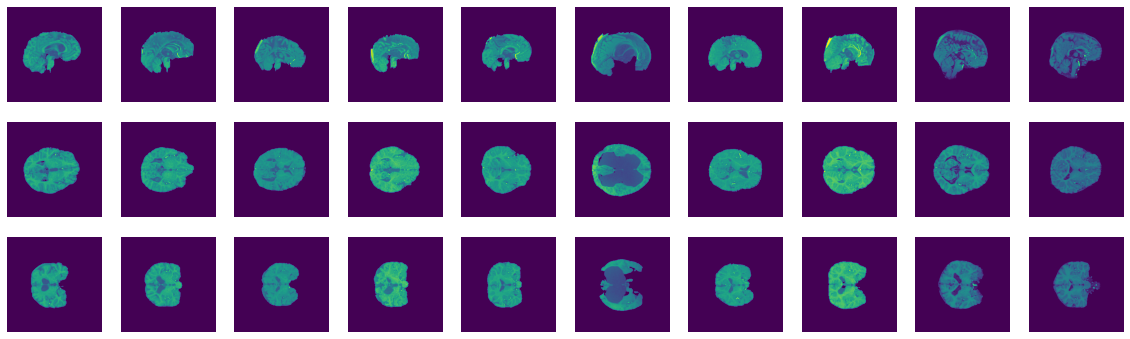

====new====


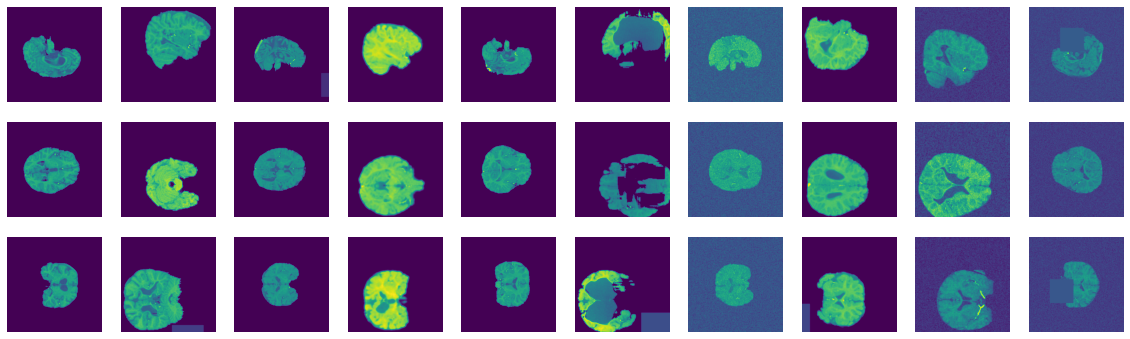

In [10]:
print("====original====")
show_images(simple_images[0])

print("====new====")
show_images(images[0].as_cpu(), channel = 0 ) #channel = 0 because looking at the first channel

In [11]:
images[0].as_cpu().as_array().shape


#deleting pipeline memory, 
del pipe, images

dali.backend.ReleaseUnusedMemory()

## X.3. Making Dataset and DataLoader!
* PyTorch DALI : https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/frameworks/pytorch/pytorch-basic_example.html 
* External data  : https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/general/data_loading/external_input.html



밑의 dataloader fetch하는 것 참조하기! (from dali_loader thing)

```python
def fetch_dali_loader(imgs, lbls, batch_size, mode, **kwargs):
    assert len(imgs) > 0, "Empty list of images!"
    if lbls is not None:
        assert len(imgs) == len(lbls), f"Number of images ({len(imgs)}) not matching number of labels ({len(lbls)})"

    if kwargs["benchmark"]:  # Just to make sure the number of examples is large enough for benchmark run.
        batches = kwargs["test_batches"] if mode == "test" else kwargs["train_batches"]
        examples = batches * batch_size * kwargs["gpus"]
        imgs = list(itertools.chain(*(100 * [imgs])))[:examples]
        lbls = list(itertools.chain(*(100 * [lbls])))[:examples]
        mode = "benchmark"

    pipeline = PIPELINES[mode]
    shuffle = True if mode == "train" else False
    dynamic_shape = True if mode in ["eval", "test"] else False
    load_to_gpu = True if mode in ["eval", "test", "benchmark"] else False
    pipe_kwargs = {"imgs": imgs, "lbls": lbls, "load_to_gpu": load_to_gpu, "shuffle": shuffle, **kwargs}
    output_map = ["image", "meta"] if mode == "test" else ["image", "label"]

    if kwargs["dim"] == 2 and mode in ["train", "benchmark"]:
        batch_size_2d = batch_size // kwargs["nvol"] if mode == "train" else batch_size
        batch_size = kwargs["nvol"] if mode == "train" else 1
        pipe_kwargs.update({"patch_size": [batch_size_2d] + kwargs["patch_size"]})

    rank = int(os.getenv("LOCAL_RANK", "0"))
    if mode == "eval":  # We sharded the data for evaluation manually.
        rank = 0
        pipe_kwargs["gpus"] = 1

    pipe = pipeline(batch_size, kwargs["num_workers"], rank, **pipe_kwargs)
    return LightningWrapper(
        pipe,
        auto_reset=True,
        reader_name="ReaderX",
        output_map=output_map,
        dynamic_shape=dynamic_shape,
    )
```

이걸 이런식으로 부르더라 (from `DataModule`)
```python
    def train_dataloader(self):
        return fetch_dali_loader(self.train_imgs, self.train_lbls, self.args.batch_size, "train", **self.kwargs)

    def val_dataloader(self):
        return fetch_dali_loader(self.val_imgs, self.val_lbls, 1, "eval", **self.kwargs)

    def test_dataloader(self):
        if self.kwargs["benchmark"]:
            return fetch_dali_loader(self.train_imgs, self.train_lbls, self.args.val_batch_size, "test", **self.kwargs)

```



### 어쩌면 dataset/datalodr 다 없애고 하나로 통합해야할수도? 
```python
dali_iter = DALIGenericIterator(pipes, ['data', 'label'], reader_name='Reader')

for i, data in enumerate(dali_iter):
    # Testing correctness of labels
    for d in data:
        label = d["label"]
        image = d["data"]

```
위에서 보듯이, `pipe`를 그냥 넣고 DALIGenericIterator하면 pipeline이 iterator (dataloader)가 되어서, for loop을 돌려서 key 값으로 빼오기만 하면 됨!)


###  steps : 
1. label도 return하도록 pipeline을 바꾸기 (i.e. returns tuple of data and labels) 
    * (그 dataset.py에서 UKBDatasetdl 받는 input들을 `fetch_dataloader` 이 그대로 받아와서, 이것을 pipeline에 넣어서 dataloader을 꺼내도록 하기)  ==> in DP mode
    * 기존의 dataset.py 랑 dataloader만드는 것을 dali_loader로 합쳐야함!! (label불러오고 하는 것등등)
        * 이것을 fetch_loader의 역할로 하기!)
        * 문제 : train_sampler같은 random sampler을 device마다 자동으로 다르게 할 수 없나?  => https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/general/multigpu.html
            * 위의 사이트처럼, readers 에서 sharding하면 된데!
            
    * 여기 보기 : https://github.com/NVIDIA/DALI/issues/1175 !!
2. try to see if DDP works
3. 그 DALI batch size랑 model batch size랑 다르게 하기 

Extenral source는 일단 하지 말기! (복잡함.. pipeline다시짜야함, as can be seen here : Extenral source + pytorch : https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/frameworks/pytorch/pytorch-external_input.html)

### X.3.1. DDP 에서 되도록 Randomsampler의 alternative를 해보기  (using sharding and so on )


**한것**
* `fn.readers.file` 에서 file_root받게 해서, 특정 folder내의 모든 것을 받도록 했는데, 이걸 **list of file dirs"로 받도록 바꿈!
* added shard_id, num_shards as arugments for the Pipeline => 이제 dataloader에서 따로따로 받아오게 함! 
    * RandomSampler대신에 `fn.readers.file` 에서 sharding 받도록 하기 => 성공!
* train loop후 dali pipeline free memory 하기 => done ((used `del` and `dali.backend.ReleaseUnusedMemory()`)
* seed 값 implmeent, made it transfer to the GenericPipeline thing 
* aug_seed, shard_seed를 나눠서 원하는 대로 자유자제로 할 수 있게 함 
    * 이제, DDP의 `set_epoch`과 같은 효과를 누릴 수 있따 
* create valid version (cutout only, no aug and so on) (only cutout or only loading)
* label을 받아서 return 하게 하기 
    * `readers.numpy` 에는 labels 옵션이 없어서 어떻게 넣어줄지 모르겠다 
    * `get_property`로 하려고 했는데, numpy reader는 안되는듯? 그래서 그 두번째 option인, `.npy`로 저장을 해가지고 거기서 불러온느 걸로 하려고 
        * 일단은 그 label을 따로 npy로 저장해서 불러오도록 만듬 
* X.4에서 보듯이, single shard 내에서 전체 dataset을 다 본다.. (not only part of the dataset)(
    * 이게 내가 .run()을 두번 해서 그런건지, 아니면 문제가 있는건지 모르겠다... 한번 공부해보기
    * SOLVED!! DALIGeneric Iterator로 dataloader처럼 만들어서 하면 이런 문제가 없음


**해야하는 것**
* resize/pad optoin 추가하기 
    * (https://github.com/Transconnectome/VAE_ADHD/blob/693c86d86ec965375298acb3cdaed01cc2fd05a1/junbeom_finetuning/dataset_BT.py#L28) 보고 implement 하기! 
    * 이렇게 해야하는 이유 : torch dataloader들어갈때 batch 내의 sample들의 이미지 shape이 일정해야해서 (https://github.com/NVIDIA/DALI/issues/4080)
* `labels` optoin이 DALI 1.25 에서 나오면 그걸로 바꾸기! 
* batch size 가 다르게 하기 (data loading시와 model training 시)
* 이제 실제로 그 옮기기만 해도 될수도??
* multi_node : 하려면 밑에서처럼 조금 바꾸야한데
    * https://github.com/NVIDIA/DALI/issues/2253
* multigpu : resnet예시 밑에 보기 (shard number 을 rank값을도 둔다던지 하는, smart하게 DDP + DALI하는 법 나와있다)
    * https://github.com/NVIDIA/DALI/blob/main/docs/examples/use_cases/pytorch/resnet50/main.py

* CL용으로 도 하나 만들기 (don't modify this, as this will be used again and again) : x 를 두번 augmentation (with same data, different randomized augmentation)을 하기
     * 이거는 새로운 .py에 하기 => x를 두가지 다른 augmentatino을 거쳤을떄 나오는 결과를 하기 (dataset.py가 이렇게 한다)
     * pipeline두개를 다른 seed값을 불러와서 하는 것보다는, pipeline자체에서 두 img를 return하도록 하는게 더 좋지 않을까? 
* reader_name을 넣어서 dataloader만들기! (X.5참조)
* 주의 : lbls path, data path가 서로 corresponding하게 같은 순서여야한다!!




### ======**당장 해야하는것**======


`load_resize_data` 에서 resize를 성공적으로 해야함! https://github.com/NVIDIA/DALI/issues/2492 여기 보기! 


#### Basic Code (for collapse)

In [3]:
##trying to just do regular stuff
from nvidia.dali.pipeline import Pipeline
from nvidia import dali
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali"

def random_augmentation(probability, augmented, original):
    """
    * probability : prob of returning augmented (instead of original)
    * augmented : augmented image (fn거친 것)
    * original : original image (before going through augmented thing)
    """
    condition = fn.cast(fn.random.coin_flip(probability=probability), dtype=types.DALIDataType.BOOL)
    neg_condition = condition ^ True
    return condition * augmented + neg_condition * original

class GenericPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, imgs, lbls, aug_seed, shard_seed, shard_id, num_shards, **kwargs):
        super().__init__(batch_size, num_threads, device_id, seed = aug_seed)
        #my additions
        
        self.multi_channel = kwargs["multi_channel"]
        self.shard_seed = shard_seed
        self.shard_id = shard_id
        self.num_shards = num_shards
        if self.multi_channel : 
            raise NotImplementedError("make sure that the multi-channel (DWI) works with dali (especially the crop and cutout)")
        self.resize_method = kwargs["resize_method"]
        self.resize_shape = kwargs["resize_shape"]
        
        if self.resize_method : #i.e. resize shape is not None
            if not self.resize_shape : #sanity check
                raise ValueError(f"you specified resize method {self.resize_method}, and therefore the shape should've been specified, but got {self.resize_shape}")
                
            self.resize_shape = types.Constant(np.array(self.resize_shape), dtype=types.INT64) #make it into int
            self.resize_shape_float = 1.0*self.resize_shape #floatized resize_shape DALI data thing 
        else : #i.e. resize_method is None or False :
            if self.resize_shape : 
                raise ValueError(f"since resize_method is None, the resize_shape should also be None! ")
        
        self.kwargs = kwargs
        self.dim = kwargs["dim"]
        self.device = device_id
        #self.layout = kwargs["layout"]
        self.load_to_gpu = kwargs["load_to_gpu"]
        self.input = self.get_reader(imgs, name = "ReaderX") #list of image directories
        self.label = self.get_reader(lbls, name = "ReaderY")
        #self.labels = kwargs["labels"] # list of labels not done yet, as version 1.25 is neede
        #self.cdhw2dhwc = ops.Transpose(device="gpu", perm=[1, 2, 3, 0])            
                
    def get_reader(self, data, name):
        """
        * data : LIST of abs dir of data files 
        """
        return fn.readers.numpy(files = data, #gets the list of files 
                                device = 'cpu',
                                shard_id = self.shard_id, num_shards = self.num_shards,
                                seed = self.shard_seed, random_shuffle = True, name = name,
                                pad_last_batch = True) #random_shuffle없으면, seed가 달라도 똑같은 데이터를 sharding한다  
        
        """
        ADD the options below when needed (일단은 loading하는 것만 함)
        """
        #return ops.readers.Numpy(
        #    files=data,
        #    device="cpu",
        #    read_ahead=True,
        #    dont_use_mmap=True,
        #    pad_last_batch=True,
        #    shard_id=self.device,
        #    seed=self.kwargs["seed"],
        #    num_shards=self.kwargs["gpus"],
        #    shuffle_after_epoch=self.kwargs["shuffle"],
        #)

    def load_resize_data(self):
        img_cpu = self.input
        img_cpu = fn.cast(img_cpu, dtype = types.FLOAT) #npy가 double로 로딩된 경우, 에러가 떠서 32fp로 부까기 
            
            
        if self.load_to_gpu:
            img = img_cpu.gpu()
        
        if not self.kwargs['multi_channel'] :
            img = img[dali.newaxis] #add one additional axis if not multi channel
        img = fn.reshape(img, layout = "CDHW") #resahpe the metadata
        
        ###여기다다 resize하면 됨 
        #일단 좀따 해보자 
        ##https://github.com/NVIDIA/DALI/issues/2492
        if self.resize_method == "reshape" :             
            img = fn.resize(img, size = self.resize_shape_float, mode = "default")#[1.0*i for i in self.resize_shape]
        elif self.resize_method == "padcrop" : 
            raise NotImplementedError("Not done yet ")
        elif self.resize_method == None : 
            pass
        else : 
            raise ValueError(f"{self.resize_method} is not one of the possible options")
            
        if self.resize_method : 
            org_shape = self.resize_shape_float
        else : 
            org_shape = fn.shapes(img_cpu) #get org shape from img_cpu, (not resized)        
        
        return img, org_shape # img_cpu #, label #reutrn img_cpu cuz sometimes it's needed

    def make_dhwc_layout(self, img, lbl):
        img, lbl = self.cdhw2dhwc(img), self.cdhw2dhwc(lbl)
        return img, lbl

    def crop(self, data):
        return fn.crop(data, crop=self.patch_size, out_of_bounds_policy="pad")

    def crop_fn(self, img, lbl):
        img, lbl = self.crop(img), self.crop(lbl)
        return img, lbl

    def transpose_fn(self, img, lbl):
        img, lbl = fn.transpose(img, perm=(1, 0, 2, 3)), fn.transpose(lbl, perm=(1, 0, 2, 3))
        return img, lbl
        

class TrainPipeline_IMPROVED(GenericPipeline):
    def __init__(self, batch_size, num_threads, device_id, imgs, lbls, aug_seed, shard_seed, 
                 shard_id, num_shards, tf = "all_tf", **kwargs):
        """
        * tf : which tf to use (all_tf, cutout, crop, none)
        """
        super().__init__(batch_size, num_threads, device_id, imgs, lbls, aug_seed, shard_seed, 
                         shard_id, num_shards, **kwargs)
        #self.oversampling = kwargs["oversampling"]
        self.tf = tf
        
        
    def flips_fn(self, img, prob = 0.5):
        #prob : 0.5, as in before
        kwargs = {
            "horizontal": fn.random.coin_flip(probability=0.5),
            "vertical": fn.random.coin_flip(probability=0.5),
        }
        if self.dim == 3:
            kwargs.update({"depthwise": fn.random.coin_flip(probability=0.5)})
        return random_augmentation(prob, fn.flip(img, **kwargs), img) #kwargs : horizontal, vertical and so on (whether to flip in those dir or not)
    
    def blur_fn(self, img, prob = 0.5):
        #prob, sigma range를 yAware에 맞춤
        img_blurred = fn.gaussian_blur(img, sigma=fn.random.uniform(range=(0.1, 1)))
        return random_augmentation(prob, img_blurred, img)
    
    def noise_fn(self, img, prob = 0.5):
        #random noise level (between 0.1 and 1 becasue that's what was used in org)
        std = fn.random.uniform(range = [0.1,1]) 
        img_noised = fn.noise.gaussian(img , stddev = std)
        return random_augmentation(prob, img_noised, img) 
    
    def crop_fn(self,img, org_shape, crop_size, type = 'random', resize = False, prob = 0.5):
        """
        * img : original image
        * org_shape : original shape (cpu shape data node)(gpu면 안됨, gpu node끼리는 못주기에)
        * crop_size : size of the crop (single float value b/w 0~1) (dim 마다 다르게 하는 거는 몰라서 적용안함)
        * type : 
            * "random" : random start point 
            * "center" : not implemented (안쓰임)
        * resize : resize여부 resize시켜서 original img와 같은 dim을 가지게 하는가?        
        """
        #need to add zoom later
        patch_dim = crop_size*org_shape #0.75면 shape자체가 0.75배씩됨 #float임! (그래도 되더라)
        if type == "center" : 
            raise NotImplementedError("center not implemented yet")
        elif type == "random" : 
            kwargs = {
                "crop_pos_x" : fn.random.uniform(range = [0.0, 1.0]),
                "crop_pos_y" : fn.random.uniform(range = [0.0, 1.0]),
                "crop_pos_z" : fn.random.uniform(range = [0.0, 1.0]), #random값이 0~1이어도 되는 것이, 1예가 알아서 해주는 듯 
            } 
        else : #default (not used)
            kwargs = {}
            
        img_cropped = fn.crop(img, crop = patch_dim, **kwargs)
        
        if resize : 
            img_cropped_resized = fn.resize(img_cropped, size = fn.cast(org_shape, dtype = types.FLOAT)[0:3])#org_shape)
            return random_augmentation(prob, img_cropped_resized, img)#random_augmentation(0.5, img_cropped_resized, img)
        else : 
            return img_cropped
            #주의 : random_augmentation은 안됨 왜냐하며,ㄴ "will not return random_aug because the output shape will be different, so random_aug cannot be applied (cannot broadcast)")
    
    def cutout_fn(self, img, org_shape, cutout_size, anchor_type = "random", prob = 0.5):
        """
        * img : original image
        * org_shape : origina shape
        * cutout_size : float or "random", if float (0~1)사이, makes a cube to use 
        * anchor_type : type of anchor, "center" or "random"
        #dali does not have native cutout implemented, but took taken inspiration from the erase operator (https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/general/erase.html) 
        """
        if type(cutout_size) == float : 
            cutout_dim = cutout_size * org_shape
        elif cutout_size == "random":
            cutout_size = fn.random.uniform(range = [0.0, 1.0], shape = 1) 
            cutout_dim = cutout_size * org_shape
        else : 
            raise ValueError(f"provided cutout_size argument {cutout_size} is invalid")
            
        cutout_dim = cutout_size * org_shape 
        
        if anchor_type == "random": 
            anchor = fn.random.uniform(range = [0.0, 1.0], shape = self.dim) #3차웜이면 TensorList of 3 float values를 만듬
        elif anchor_type == "center" :
            None
        img_cutout = fn.erase(img, anchor = anchor, shape = cutout_dim,
                             normalized_anchor = True,
                             normalized_shape = False,
                             fill_value = 1.0) #fill_value 1.0 for testing purposes
        return random_augmentation(prob, img_cutout, img)
        
    def define_graph(self):
        #numpy reading은 이미 generic __init__에서 함 
        
        #loading and stuff
        img, org_shape = self.load_resize_data() #move to GPU
        
        #acutal aug, prob of doing each : 0.5, except normalize, which is 100%
        img = fn.normalize(img, axis_names = "DHW") #"DHW" so that channel-wise normalization is not done 
        if self.tf == "all_tf" : 
            img = self.flips_fn(img)
            img = self.blur_fn(img)
            img = self.noise_fn(img)
            img = self.cutout_fn(img, org_shape, cutout_size = 0.25) #cutout_size : random가능, but not recommended
            img = self.crop_fn(img, org_shape, crop_size = 0.75, type = "random", resize = True) 
        elif self.tf == "cutout" : 
            #cutout has prob 100% in "cutout" because 1. how MICCAI paper did it , 2. cutout paper found 100% aug all the time was best, assuming that the 
            #cutout box could partially outside of the image itself (which is true in our version of cutout implementation)
            img = self.cutout_fn(img, org_shape, cutout_size = 0.25, prob = 1.0) 
        elif self.tf == "crop" : 
            img = self.crop_fn(img, org_shape, crop_size = 0.75, type = "random", resize = True, prob = 1.0) 
        elif self.tf == "none" : 
            pass
        else : 
            raise ValueError(f"provided {self.tf} option is not valid...")
        
        print("flip here enalbes any combinations of three types of flipping, while the original only had one")
        print("therefore, ipmlement the original yAware version of flipping too (or not..")
        print("in normalizaiton, make sure that even when doing multichannel, channel-wise normalization is not done (only single channel-wise normalization(즉, axis_names = 'DHW'가 잘작동하는지 보기 ")
        print("also see if dali batch size and gpu batch size have to be the same (즉, 16짜리 dali를 두번돌려서 2*16 = 32W짜리 model batch size에 맞춰도 되나?")
        print("DDP + DALI? (data sampler이 DDP스면 rank마다 다르게 주는 걸로 알고있는데, 이거에 맞게 DALI는 어떻게 되는거지?")
        print("also crop/cutout patch size could also be made random if needed? ")
        
        #fn.stack
        
        return img, self.label #fn.get_property(img_cpu, key = "source_info") #didn't work, asked NVIDIA
    
#wheng making the other versions, just super.__init__ from the original Training thing and add onto it !

#### Running (modify and so on )

https://github.com/NVIDIA/DALI/issues/1175
여기 참조하기!

https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/general/multigpu.html#Sharding


In [24]:
kwargs = {
    "load_to_gpu" : True, 
    "multi_channel" : False,  #if DWI : maybe multichannel?
    ###below : not done yet..
    "dim": 3,
    "num_workers": 4,
    "resize_method" : "reshape", #reshape, padcrop, None 세가지 가능 
    "resize_shape" : [80,80,80], #None도 가능 #the resize shape, without the channel (multichannel용으로 하면 고쳐야할수도)
    #"gpus": 1,
    #"nvol": 0,
    #"layout": "CDHW", #fn.reshape의 varialbe
    #"overlap": self.args.overlap,
    #"benchmark": False,
    #"oversampling": 0.5, #self.args.oversampling, (argument of fn.segmentation.random_object_bbox)
    #"test_batches": self.args.test_batches,
    #"train_batches": selfnum.args.train_batches,
    #"invert_resampled_y": self.args.invert_resampled_y,
    #"meta" : meta
}

#여기에 resisze method, reijssze size 넣고, 이것을 바탕으로 그 if 문해서 fn 하기  => 이거는 config 에 넣기 (should be same for all, training and valid)

print("it may be better to just remove multi_channel? (since it seems that multichannel is a necessity for DALI to work..>?? (see the github things)")

it may be better to just remove multi_channel? (since it seems that multichannel is a necessity for DALI to work..>?? (see the github things)


In [25]:
print("밑에 것 작동 안할 것이다. label을 np readers에서 하려고 했는데 그 기능이 없다고 해서... 어떻게 하지..?")
print("즉, 아직 그 labels 를 덜 implement한상태이다, github다시 해보고 확인해보기 ")

밑에 것 작동 안할 것이다. label을 np readers에서 하려고 했는데 그 기능이 없다고 해서... 어떻게 하지..?
즉, 아직 그 labels 를 덜 implement한상태이다, github다시 해보고 확인해보기 


In [26]:
from glob import glob
import torch
import numpy as np 
import os 

data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali"
label_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali_labels"

subsample_path = glob(data_path + "/sub-11*") #added so that 


#======seperately saving the labels ============#
labels = [int(i[-10:-4]) for i in subsample_path]
for i in labels : 
    npy = np.array(i)
    np.save(os.path.join(label_path, f"{i}.npy"),npy)
lbls_path = glob(label_path + "/*") #added so that 

####must be sorted!!! (the order of subsample_path files should match the corresponding lbls thing 
subsample_path.sort()
lbls_path.sort()
#===============================================#

if torch.cuda.device_count() != 1 :
    rank_1 = 0 #DDP로 set 
    rank_2 = 1
    world_size = 2
    epoch = 0
    print("multiple_devices")
else :  #single gpu, : set same
    rank_1 = 0
    rank_2 = 0
    world_size = 1 
    epoch = 0
###########################

"""
two seeding! aug_seed (pipeline 정의시 제공해야하는 `self.seed`), shard_seed exist
* aug_seed : augmentaiton seed
    * shard_seed가 달라서 받는 데이터가 다르더라도 aug_seed가 같으면 같은 augmentatino을 한다 
* shard_seed : sharding seed (for sharding data)  => must be same for the epoch 
    * aug_seed가 달라도 shard_seed, shard_id가 같으면 같은 데이터를 받아옴 (but diff aug)
      ==> potentially useful for contrastive learning (two views of the same image)
          (or, pipeline자체에서 두개를 return하도록 해도 되고 (like the dataset.py)
    * MUST BE SAME FOR ALL PIPELINE FOR A GIVEN EPOCH
        * because each pipeline should recieve their correspondign data depnding on the shard seed and the shard id (for a given epoch)
    * readers.numpy에서 random_shuffle이 True여야지 takes effect (아마도 그래야 seed값에 따라 shuffle후 shard를 나누느듯)
* 이렇게 두개로 나눈 이유 : seed값이 같으면, shard_id가 다르더라도 (즉, 제공되는 데이터가 다르더라도) 같은 augmentatino step을 거침따라서, randomize 제대로 하기 위해서 이렇게 함...?
"""

"""
* same data, diff tf : aug seed를 다르게 하기, 나머진 같게
* diff data, same tf : shard_seed, shard_id다르게 하기, 나머진 같게
* diff data, diff tf : 모두다 다르게 하기 
"""

##first pipe (sharded)
pipe_1 = TrainPipeline_IMPROVED(batch_size = 16, num_threads = kwargs['num_workers'],
                                device_id = rank_1, 
                                imgs = subsample_path, lbls = lbls_path,
                                aug_seed = 0, #controls what augs will be done 
                                shard_seed = epoch, shard_id = rank_1, num_shards = world_size, #controls which data each shard will get (random sampler)
                                tf = "none", #perform all transformations
                                **kwargs)
pipe_1.build()
images_1 , labels_1= pipe_1.run() #still different images becusae "random_shuffle = True"

##second pipe (sharded)
rank_2 = rank_1 #reset to same, when needed 
pipe_2 = TrainPipeline_IMPROVED(batch_size = 10, num_threads = kwargs['num_workers'], 
                                device_id = rank_2, 
                                imgs = subsample_path, lbls = lbls_path,
                                aug_seed = 1,
                                shard_seed = epoch, shard_id = rank_2, num_shards = world_size, #controls which data each shard will get (random sampler)
                                tf = "all_tf", #only perform cutout
                               **kwargs)

pipe_2.build()
images_2, labels_2= pipe_2.run()
print("===지금 문제다!!! diff shard_seed, same, shard_id, 등등인데 같은 data를 가져옴 => random off 여서 그랬따 ")

multiple_devices
flip here enalbes any combinations of three types of flipping, while the original only had one
therefore, ipmlement the original yAware version of flipping too (or not..
in normalizaiton, make sure that even when doing multichannel, channel-wise normalization is not done (only single channel-wise normalization(즉, axis_names = 'DHW'가 잘작동하는지 보기 
also see if dali batch size and gpu batch size have to be the same (즉, 16짜리 dali를 두번돌려서 2*16 = 32W짜리 model batch size에 맞춰도 되나?
DDP + DALI? (data sampler이 DDP스면 rank마다 다르게 주는 걸로 알고있는데, 이거에 맞게 DALI는 어떻게 되는거지?
also crop/cutout patch size could also be made random if needed? 
flip here enalbes any combinations of three types of flipping, while the original only had one
therefore, ipmlement the original yAware version of flipping too (or not..
in normalizaiton, make sure that even when doing multichannel, channel-wise normalization is not done (only single channel-wise normalization(즉, axis_names = 'DHW'가 잘작동하는지 보기 
also see if dali b

In [27]:
images_1.as_cpu().as_array().shape

(16, 1, 80, 80, 80)

====first_shard====


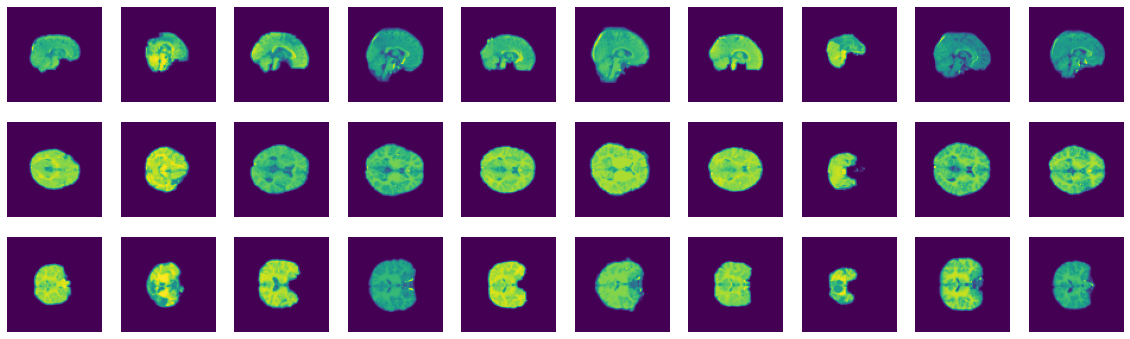

[111608 111791 111609 111527 111168 111550 111564 111591 111572 111790
 111159 111607 111618 111556 110967 111727]
====second_shard====


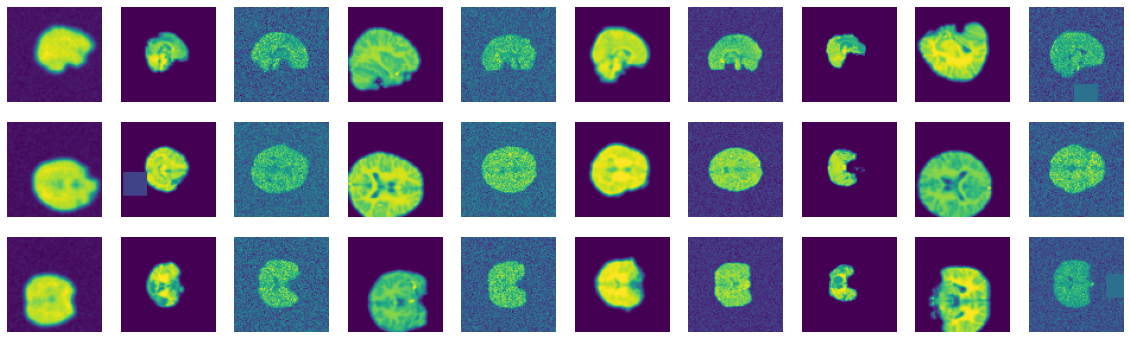

[111608 111791 111609 111527 111168 111550 111564 111591 111572 111790]
====second_shard, run again====


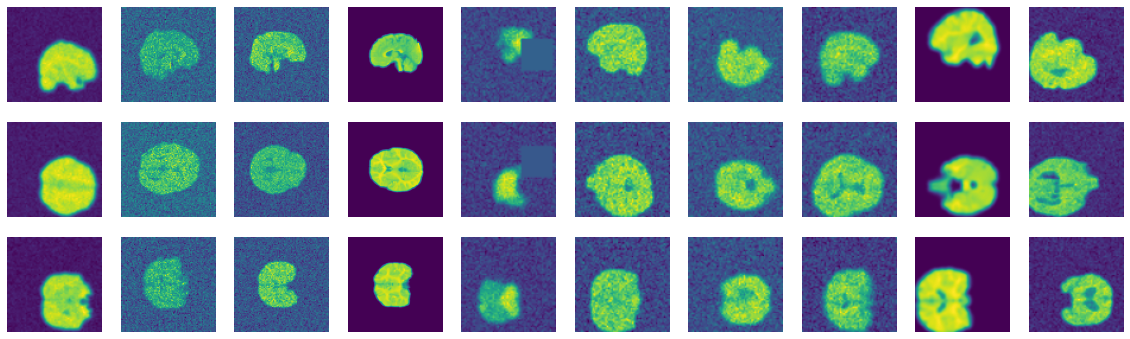

[111159 111607 111618 111556 110967 111727 111539 111802 111559 111537]


In [28]:
#print("====original====")
#show_images(simple_images[0])
print("====first_shard====")
show_images(images_1.as_cpu(), channel = 0 ) #channel = 0 because looking at the first channel
#show_images(images_1[0].as_cpu(), channel = 0 ) #if only retruning the img, then [0]을 여기처럼 붙여야함
print(labels_1.as_array())

print("====second_shard====")
show_images(images_2.as_cpu(), channel = 0 ) 
print(labels_2.as_array())

#seed, shardid, 가 같으면 , pipeline 1, 2가 같은 짓을 한다 (therefore, epoch값을 seed값을 할때 고려해줘서 넣어야 할듯 => ASK GITHIUB


print("====second_shard, run again====")
images_2, labels_2= pipe_2.run()
show_images(images_2.as_cpu(), channel = 0 ) 
print(labels_2.as_array())

#### X.3.1.X 부록 : dataloader로 만들어보기 (using Generic Iterator)

In [29]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator
from nvidia.dali.plugin.base_iterator import LastBatchPolicy

##trying iterator 
data_dir_list = ['/hpcgpfs01/scratch/dyhan316/ABCD_T1_cropped/2.sMRI_freesurfer/NDARINVKMBXR817.npy', '/hpcgpfs01/scratch/dyhan316/ABCD_T1_cropped/2.sMRI_freesurfer/NDARINV62P1BPWE.npy', '/hpcgpfs01/scratch/dyhan316/ABCD_T1_cropped/2.sMRI_freesurfer/NDARINVYRW56GJ2.npy', '/hpcgpfs01/scratch/dyhan316/ABCD_T1_cropped/2.sMRI_freesurfer/NDARINVBZ0JV1FF.npy', '/hpcgpfs01/scratch/dyhan316/ABCD_T1_cropped/2.sMRI_freesurfer/NDARINVXGFXPB14.npy', '/hpcgpfs01/scratch/dyhan316/ABCD_T1_cropped/2.sMRI_freesurfer/NDARINV5VWG4VXE.npy']
lbl_dir_list = ['/direct/sdcc+u/dyhan316/VAE_ADHD/yAwareContrastiveLearning/tmp_save_label/NDARINVKMBXR817.npy', '/direct/sdcc+u/dyhan316/VAE_ADHD/yAwareContrastiveLearning/tmp_save_label/NDARINV62P1BPWE.npy', '/direct/sdcc+u/dyhan316/VAE_ADHD/yAwareContrastiveLearning/tmp_save_label/NDARINVYRW56GJ2.npy', '/direct/sdcc+u/dyhan316/VAE_ADHD/yAwareContrastiveLearning/tmp_save_label/NDARINVBZ0JV1FF.npy', '/direct/sdcc+u/dyhan316/VAE_ADHD/yAwareContrastiveLearning/tmp_save_label/NDARINVXGFXPB14.npy', '/direct/sdcc+u/dyhan316/VAE_ADHD/yAwareContrastiveLearning/tmp_save_label/NDARINV5VWG4VXE.npy']
pipe_1 = TrainPipeline_IMPROVED(batch_size = 5, num_threads = 4,
                                    device_id = rank_1, 
                                    #imgs = data_dir_list, lbls = lbl_dir_list, #doesn't work
                                    imgs = subsample_path, lbls = lbl_dir_list, #works
                                    #imgs = subsample_path, lbls = lbls_path, #works
                                    aug_seed = 0, #controls what augs will be done 
                                    shard_seed = epoch, shard_id = rank_1, num_shards = world_size, #controls which data each shard will get (random sampler)
                                    tf = "all_tf", **kwargs)
pipe_1.build()

dali_iter = DALIGenericIterator([pipe_1], ['data', 'label'], 
                                reader_name = "ReaderX",
                                last_batch_policy = LastBatchPolicy.DROP)

for i, data in enumerate(dali_iter):
    for d in data : 
        image = d['data']
        label = d['label']
        print(image.shape)
        print(label)
    if i == 20:
        break

flip here enalbes any combinations of three types of flipping, while the original only had one
therefore, ipmlement the original yAware version of flipping too (or not..
in normalizaiton, make sure that even when doing multichannel, channel-wise normalization is not done (only single channel-wise normalization(즉, axis_names = 'DHW'가 잘작동하는지 보기 
also see if dali batch size and gpu batch size have to be the same (즉, 16짜리 dali를 두번돌려서 2*16 = 32W짜리 model batch size에 맞춰도 되나?
DDP + DALI? (data sampler이 DDP스면 rank마다 다르게 주는 걸로 알고있는데, 이거에 맞게 DALI는 어떻게 되는거지?
also crop/cutout patch size could also be made random if needed? 
torch.Size([5, 1, 80, 80, 80])
tensor([[-1.4716],
        [ 1.6117],
        [ 0.2712],
        [ 0.2712],
        [ 0.2712]])
torch.Size([5, 1, 80, 80, 80])
tensor([[-0.1310],
        [ 0.4052],
        [-1.4716],
        [-1.4716],
        [-1.4716]])
torch.Size([5, 1, 80, 80, 80])
tensor([[-1.4716],
        [ 1.6117],
        [ 0.2712],
        [ 0.2712],
        [ 0.2712]])


In [30]:
print(np.load(subsample_path[0]).dtype, 
      np.load(lbls_path[0]).dtype,
      np.load(data_dir_list[0]).dtype,
      np.load(lbl_dir_list[0]).dtype,
     ) #float 64라서 에러뜨는 듯! 


print(np.load(subsample_path[0]).shape, 
      np.load(lbls_path[0]).shape,
      np.load(data_dir_list[0]).shape,
      np.load(lbl_dir_list[0]).shape,
     )



uint8 int64 float64 float32
(256, 256, 256) () (155, 165, 186) (1,)


In [31]:
#deleting pipeline memory
del pipe_1, images_1
del pipe_2, images_2

dali.backend.ReleaseUnusedMemory()

In [14]:
#nvidia.dali.backend_impl.TensorListGPU
len(subsample_path)

86

## X.4. inspecting sharding behvaior

In [1]:
#mkaing custom data to play with 
import numpy as np 
import os 
os.makedirs("./sample_npy_files", exist_ok = True)
for i in range(20):
    arr = np.array([i])
    np.save(f"./sample_npy_files/{i}.npy", arr)


In [83]:
##trying out seeing sharding behavior 
from nvidia.dali.pipeline import Pipeline
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

import os 

#data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali_smaller"
data_path = "./sample_npy_files"
print("number of samples : ", len(os.listdir(data_path)))

def sharded_pipeline(BATCH_SIZE,device_id, shard_id, num_shards, seed, shuffle, pad_last_batch):
    pipe = Pipeline(batch_size= BATCH_SIZE, num_threads=4, device_id=device_id)
    with pipe:
        img = fn.readers.numpy(file_root = data_path, shard_id = shard_id,
                               num_shards = num_shards, seed = seed, random_shuffle = shuffle,
                              pad_last_batch = pad_last_batch)
        img = img.gpu()
        pipe.set_outputs(img)

    return pipe

number of samples :  20


In [84]:
BATCH_SIZE = 6
pipe_one = sharded_pipeline(BATCH_SIZE = 6, device_id=0, shard_id=0, 
                            num_shards=2, seed = 0, shuffle = False,
                            pad_last_batch = True)
pipe_one.build()

simple_images = pipe_one.run()
print(simple_images[0].as_cpu().as_array().T)

simple_images = pipe_one.run()
print(simple_images[0].as_cpu().as_array().T)


#new epoch, because shuffle = True, shuffles the thing 

simple_images = pipe_one.run()
print(simple_images[0].as_cpu().as_array().T)


simple_images = pipe_one.run()
print(simple_images[0].as_cpu().as_array().T)


simple_images = pipe_one.run()
print(simple_images[0].as_cpu().as_array().T)


[[ 0  1 10 11 12 13]]
[[14 15 16 17 17 17]]
[[18 19  2  3  4  5]]
[[6 7 8 9 9 9]]
[[ 0  1 10 11 12 13]]


## X.5. torch dataloader 식으로 만들기(Iterator thing) / trying the get_property

* LastBatchPolicy : drop,fill, partial 가능, 나는 drop 썼다 : https://docs.nvidia.com/deeplearning/dali/user-guide/docs/advanced_topics_sharding.html#nvidia.dali.plugin.base_iterator.LastBatchPolicy
* reader_name넣어야 함!

문제 : 
* loops forever : https://github.com/NVIDIA/DALI/issues/2873 size 나 reader_name을 지정해 줘야한다는데..?
* 근데.. reader_name이 뭔지 애매하다 : https://github.com/NVIDIA/DALI/issues/4177
    * Reader name을 세팅해주니예가 잘 멈춤... => 이렇게 하면 될듯? (근데 그 밑에서는 fn.readers.numpy 함수안에 name을 지정해줬는데, 

In [1]:
#trying to do torch iterator : https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/frameworks/pytorch/pytorch-basic_example.html
##trying to just do regular stuff
from nvidia.dali.pipeline import Pipeline
from nvidia import dali
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

import numpy as np
from nvidia.dali.plugin.pytorch import DALIGenericIterator
from nvidia.dali.plugin.base_iterator import LastBatchPolicy

data_path = "./sample_npy_files"

#GDS (gpu direct storaeg가 있어야 device = "gpu"해서 gpu에서 바로 로딩할 수 있따 

def sharded_pipeline(BATCH_SIZE,device_id, shard_id, num_shards, seed, shuffle,
                     shuffle_after_epoch, pad_last_batch):
    pipe = Pipeline(batch_size= BATCH_SIZE, num_threads=4, device_id=device_id)
    with pipe:
        img = fn.readers.numpy(file_root = data_path, shard_id = shard_id,
                               num_shards = num_shards, seed = seed, random_shuffle = shuffle,
                              pad_last_batch = pad_last_batch, shuffle_after_epoch = shuffle_after_epoch,
                               name = "TestReader")
        img = img.gpu()
        #pipe.set_outputs(img, np.arange(10)) #label : 그냥 1~10까지의 np array로 걍 정해줌
        pipe.set_outputs(img, fn.get_property(img, key = "source_info")) #label : 그냥 1~10까지의 np array로 걍 정해줌

    return pipe

In [2]:
#여기서 말한대로 get_property를 하려고 하는 중(근데 안됨)
#https://github.com/NVIDIA/DALI/issues/4713
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=0, 
                            num_shards=1, seed = 0, shuffle = False,
                            shuffle_after_epoch = False,
                            pad_last_batch = False)
pipe_one.build()
img,prop = pipe_one.run()

#print(img)
print(prop)

dlopen libcufile.so failed with error libcufile.so: cannot open shared object file: No such file or directory!. Please install libcufile.
dlopen libcufile.so failed with error libcufile.so: cannot open shared object file: No such file or directory!. Please install libcufile.


RuntimeError: Critical error in pipeline:
Error when executing GPU operator readers__Numpy encountered:
Error in thread 0: [/opt/dali/dali/util/std_cufile.cc:73] CUFile import failed: ./sample_npy_files/./10.npy. CUDA Driver API error.
Stacktrace (10 entries):
[frame 0]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali.so(+0xc151b) [0x2b291f14451b]
[frame 1]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali.so(+0x8e826) [0x2b291f111826]
[frame 2]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali.so(+0x2026f5) [0x2b291f2856f5]
[frame 3]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali.so(dali::CUFileStream::Open(std::string const&, bool, bool)+0xf1) [0x2b291f284fc1]
[frame 4]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali_operators.so(+0x3bdb67e) [0x2b29626a567e]
[frame 5]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali_operators.so(+0x3d67a8b) [0x2b2962831a8b]
[frame 6]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali.so(dali::ThreadPool::ThreadMain(int, int, bool, std::string const&)+0x1e6) [0x2b291f225fb6]
[frame 7]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali.so(+0x6ae340) [0x2b291f731340]
[frame 8]: /lib64/libpthread.so.0(+0x7dc5) [0x2b29134b4dc5]
[frame 9]: /lib64/libc.so.6(clone+0x6d) [0x2b29137c076d]

Current pipeline object is no longer valid.

### X.5.1. Checking default behavior (single shard)
(reader에 name준 것 까먹지 말기)

#### X.5.1.1 : does last batch policy work? 
Below, we see that it works well : 
* batch size 7이고, LastBatchPolicy를 FILL로 해서, 나머지 batch의 것들이 fill되었다 

In [3]:
pipe_one = sharded_pipeline(BATCH_SIZE = 4, device_id=0, shard_id=0, 
                            num_shards=1, seed = 0, shuffle = False,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)
pipe_one.build()
#DO NOT RUN pipe_one.run() #이렇게 하면 애러뜸

dali_iter = DALIGenericIterator([pipe_one], ['data', 'label'], 
                                reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)

print(dali_iter)
for i, data in enumerate(dali_iter):
    # Testing correctness of labels
    for d in data:
        label = d["label"]
        image = d["data"]
        ## labels need to be integers
        #assert(np.equal(np.mod(label, 1), 0).all())
        print(image.T)

tensor([[ 0,  1, 10, 11]], device='cuda:0')
tensor([[12, 13, 14, 15]], device='cuda:0')
tensor([[16, 17, 18, 19]], device='cuda:0')
tensor([[2, 3, 4, 5]], device='cuda:0')
tensor([[6, 7, 8, 9]], device='cuda:0')


#### X.5.1.2. Calling multiple times with shuffle on 
* reader의 shuffle을 True해도, 똑같은게 나온다!

In [4]:
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=0, 
                            num_shards=1, seed = 0, shuffle = True,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)
pipe_one.build()
dali_iter = DALIGenericIterator([pipe_one], ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)
for i, data in enumerate(dali_iter):
    for d in data:
        label = d["label"]
        image = d["data"]
        print(image.T)
print("=====")
        
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=0, 
                            num_shards=1, seed = 0, shuffle = True,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)
pipe_one.build()
dali_iter = DALIGenericIterator(pipe_one, ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)
for i, data in enumerate(dali_iter):
    for d in data:
        label = d["label"]
        image = d["data"]
        print(image.T)

tensor([[10, 17,  4,  6,  2, 12,  1]], device='cuda:0')
tensor([[ 7,  0, 15,  8, 16,  5, 18]], device='cuda:0')
tensor([[11, 14,  3, 19,  9, 13, 13]], device='cuda:0')
=====
tensor([[10, 17,  4,  6,  2, 12,  1]], device='cuda:0')
tensor([[ 7,  0, 15,  8, 16,  5, 18]], device='cuda:0')
tensor([[11, 14,  3, 19,  9, 13, 13]], device='cuda:0')


## X.5.2. Checking multiple shards

#### X.5.2.1. Seeing if Sharding Works
* we see that if num_shards 1 --> 2, less iterations done ==> **sharding works!!**

In [5]:
print("==num_shard_1==")
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=0, 
                            num_shards=1, seed = 0, shuffle = True,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)
pipe_one.build()
dali_iter = DALIGenericIterator([pipe_one], ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)
for i, data in enumerate(dali_iter):
    for d in data:
        label = d["label"]
        image = d["data"]
        print(image.T)
        
        
        
print("\n==num_shard_1, shard_id = 0==")
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=0, 
                            num_shards=2, seed = 0, shuffle = True,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)
pipe_one.build()
dali_iter = DALIGenericIterator(pipe_one, ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)
for i, data in enumerate(dali_iter):
    for d in data:
        label, image = d["label"], d["data"]
        print(image.T)

        
print("\n==num_shard_1, shard_id = 1==")
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=1, 
                            num_shards=2, seed = 0, shuffle = True,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)
pipe_one.build()
dali_iter = DALIGenericIterator(pipe_one, ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)
for i, data in enumerate(dali_iter):
    for d in data:
        label = d["label"]
        image = d["data"]
        print(image.T)

==num_shard_1==
tensor([[10, 17,  4,  6,  2, 12,  1]], device='cuda:0')
tensor([[ 7,  0, 15,  8, 16,  5, 18]], device='cuda:0')
tensor([[11, 14,  3, 19,  9, 13, 13]], device='cuda:0')

==num_shard_1, shard_id = 0==
tensor([[ 2, 16, 18,  9,  4, 19, 13]], device='cuda:0')
tensor([[3, 6, 7, 7, 7, 7, 7]], device='cuda:0')

==num_shard_1, shard_id = 1==
tensor([[ 1, 10,  5, 11,  0, 17, 14]], device='cuda:0')
tensor([[15,  8, 12, 12, 12, 12, 12]], device='cuda:0')


### X.5.3. Diff shard, shuffle after epoch

In [6]:
print("==num_shard_2, shard_id = 0,  shuffle False, shuffle after epoch False==")
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=0, 
                            num_shards=2, seed = 0, shuffle = False,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)
pipe_one.build()
dali_iter = DALIGenericIterator([pipe_one], ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)

for epoch in range(3):
    print(f"epoch : {epoch}")
    for i, data in enumerate(dali_iter):
        for d in data:
            label = d["label"]
            image = d["data"]
            print(image.T)
        
print("\n==num_shard_2, shard_id = 0, shuffle False | shuffle after epoch True  ==")
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=0, 
                            num_shards=2, seed = 0, shuffle = False,
                            shuffle_after_epoch = True,
                            pad_last_batch = True)
pipe_one.build()
dali_iter = DALIGenericIterator(pipe_one, ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)
for epoch in range(5): 
    print(f"epoch : {epoch}")
    for i, data in enumerate(dali_iter):
        for d in data:
            label, image = d["label"], d["data"]
            print(image.T)

        
print("\n==num_shard_2, shard_id = 0, shuffle True | shuffle after epoch False  ==")
pipe_one = sharded_pipeline(BATCH_SIZE = 7, device_id=0, shard_id=1, 
                            num_shards=2, seed = 0, shuffle = True,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)
pipe_one.build()
dali_iter = DALIGenericIterator(pipe_one, ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)
for epoch in range(5):
    print(f"epoch : {epoch}")
    for i, data in enumerate(dali_iter):
        for d in data:
            label = d["label"]
            image = d["data"]
            print(image.T)

==num_shard_2, shard_id = 0,  shuffle False, shuffle after epoch False==
epoch : 0
tensor([[ 0,  1, 10, 11, 12, 13, 14]], device='cuda:0')
tensor([[15, 16, 17, 17, 17, 17, 17]], device='cuda:0')
epoch : 1
tensor([[18, 19,  2,  3,  4,  5,  6]], device='cuda:0')
tensor([[7, 8, 9, 9, 9, 9, 9]], device='cuda:0')
epoch : 2
tensor([[ 0,  1, 10, 11, 12, 13, 14]], device='cuda:0')
tensor([[15, 16, 17, 17, 17, 17, 17]], device='cuda:0')

==num_shard_2, shard_id = 0, shuffle False | shuffle after epoch True  ==
epoch : 0
tensor([[ 1, 10,  3,  6,  2,  9, 13]], device='cuda:0')
tensor([[16, 19, 11, 11, 11, 11, 11]], device='cuda:0')
epoch : 1
tensor([[ 3,  2, 10, 17, 14,  8,  0]], device='cuda:0')
tensor([[16, 19,  1,  1,  1,  1,  1]], device='cuda:0')
epoch : 2
tensor([[ 8, 11,  3, 19, 16,  5, 14]], device='cuda:0')
tensor([[17,  7,  0,  0,  0,  0,  0]], device='cuda:0')
epoch : 3
tensor([[ 2, 14, 17,  5,  9,  0, 15]], device='cuda:0')
tensor([[10,  7,  1,  1,  1,  1,  1]], device='cuda:0')
epoch

### X.5.4. model, dataloader batch size 다르게 하기! https://github.com/NVIDIA/DALI/issues/4784



In [62]:
pipe_one = sharded_pipeline(BATCH_SIZE = 2, device_id=0, shard_id=0, 
                            num_shards=1, seed = 0, shuffle = False,
                            shuffle_after_epoch = False,
                            pad_last_batch = True)

pipe_one.build()
dali_iter = DALIGenericIterator(pipe_one, ['data', 'label'], reader_name = "TestReader",
                                last_batch_policy = LastBatchPolicy.FILL)


for epoch in range(2): 
    print(f"epoch : {epoch}")
    for i,data in enumerate(dali_iter) :
        inputs,  labels = data[0]["data"], data[0]["label"]
        print(inputs.T)

        
print("\n======divide========\n")
          
BATCH_SIZE = 2
MODEL_BATCH_SIZE = 8

for epoch in range(2):     
    images_list , labels_list = [],[]
    print(f"epoch : {epoch}")
    for i, data in enumerate(dali_iter) :
        image_i,  label_i = data[0]["data"], data[0]["label"]
        #print(image_i.T)
        
        images_list.append(image_i)
        labels_list.append(label_i)
        
        if len(images_list) != int(MODEL_BATCH_SIZE/BATCH_SIZE) :
            #if batch is not made yet, don't do the things below, if batch is made, then do below 
            continue 
            
        #inputs, labels that will be put in!!
        inputs = torch.cat(images_list,0) 
        labels = torch.cat(labels_list,0)
        #print(inputs.shape, labels.shape)
        print(inputs.T)
        
        images_list , labels_list = [],[] #reset 
        
print(MODEL_BATCH_SIZE/BATCH_SIZE)
print(len(dali_iter))
inputs.shape

epoch : 0
tensor([[0, 1]], device='cuda:0')
tensor([[10, 11]], device='cuda:0')
tensor([[12, 13]], device='cuda:0')
tensor([[14, 15]], device='cuda:0')
tensor([[16, 17]], device='cuda:0')
tensor([[18, 19]], device='cuda:0')
tensor([[2, 3]], device='cuda:0')
tensor([[4, 5]], device='cuda:0')
tensor([[6, 7]], device='cuda:0')
tensor([[8, 9]], device='cuda:0')
epoch : 1
tensor([[0, 1]], device='cuda:0')
tensor([[10, 11]], device='cuda:0')
tensor([[12, 13]], device='cuda:0')
tensor([[14, 15]], device='cuda:0')
tensor([[16, 17]], device='cuda:0')
tensor([[18, 19]], device='cuda:0')
tensor([[2, 3]], device='cuda:0')
tensor([[4, 5]], device='cuda:0')
tensor([[6, 7]], device='cuda:0')
tensor([[8, 9]], device='cuda:0')

======divide========

epoch : 0
tensor([[ 0,  1, 10, 11, 12, 13, 14, 15]], device='cuda:0')
tensor([[16, 17, 18, 19,  2,  3,  4,  5]], device='cuda:0')
epoch : 1
tensor([[ 0,  1, 10, 11, 12, 13, 14, 15]], device='cuda:0')
tensor([[16, 17, 18, 19,  2,  3,  4,  5]], device='cuda:0

torch.Size([8, 1])

In [44]:
int(BATCH_SIZE * i / MODEL_BATCH_SIZE) != BATCH_SIZE * i // MODEL_BATCH_SIZE

False

In [46]:
BATCH_SIZE * i // MODEL_BATCH_SIZE


2

### X.5.2. Checking if 

In [ ]:
dali_iter = DALIGenericIterator([pipe_one], ['data', 'label'], reader_name = "TestReader",last_batch_policy = LastBatchPolicy.FILL)

print(dali_iter)
for i, data in enumerate(dali_iter):
    # Testing correctness of labels
    for d in data:
        label = d["label"]
        image = d["data"]
        ## labels need to be integers
        assert(np.equal(np.mod(label, 1), 0).all())
        print(image.T)



below : trash

In [39]:
##trying out seeing sharding behavior 
from nvidia.dali.pipeline import Pipeline
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

import os 

data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali_smaller"
print("number of samples : ", len(os.listdir(data_path)))


@pipeline_def
def default_pipeline():
    img = fn.readers.numpy(file_root = data_path, seed = 0, shard_id = 0, num_shards = 2)
    return img

@pipeline_def
def shard_id_change():
    img = fn.readers.numpy(file_root = data_path, seed = 0, shard_id = 1, num_shards = 2)
    return img

shard_pipe = shard_id_change(batch_size = 5, num_threads = 4, device_id = 0)
shard_pipe.build()


@pipeline_def
def seed_change():
    img = fn.readers.numpy(file_root = data_path, seed = 1, shard_id = 0, num_shards = 2)
    return img


@pipeline_def
def only_random():
    img = fn.readers.numpy(file_root = data_path, seed = 0, shard_id = 0, num_shards = 2, 
                           random_shuffle = True)
    return img



@pipeline_def
def seed_change_with_random():
    img = fn.readers.numpy(file_root = data_path, seed = 1, shard_id = 0, num_shards = 2, 
                           random_shuffle = True)
    return img

#batch size가 그 이상할때 어떻게 되는지 보기  (batch size와 numberf of images to see is 딱 떨어짐)


number of samples :  10


In [40]:
def build_run_pipe(pipe):
    pipe.build()
    return pipe.run()

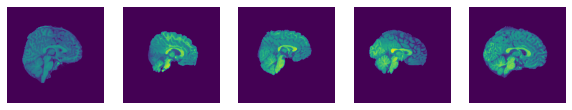

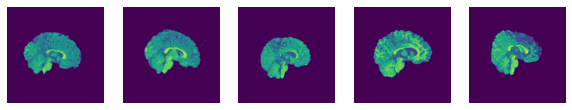

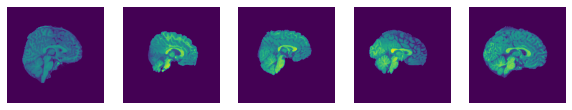

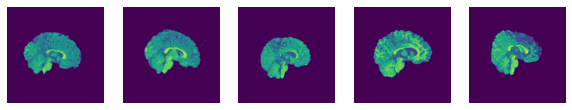

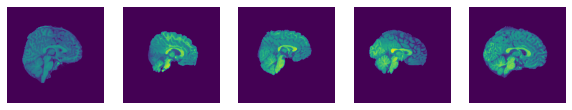

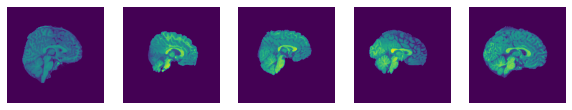

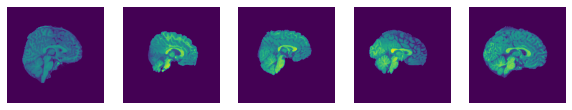

In [26]:
##problem 1 : sharded pipeline still runs through the whole data! 


default_pipe = simple_pipeline(batch_size = 5, num_threads = 4, device_id = 0)
default_pipe.build()

#shard 0, 1st run 
simple_images = default_pipe.run()
show_first_images(simple_images[0], columns = 5)

#shard 0, 2nd run 
simple_images = default_pipe.run()
show_first_images(simple_images[0], columns = 5)

#shard 0, 3rd run 
simple_images = default_pipe.run()
show_first_images(simple_images[0], columns = 5)

#shard 0, 4th run 
simple_images = default_pipe.run()
show_first_images(simple_images[0], columns = 5)


#shard 0, 5th run 
simple_images = default_pipe.run()
show_first_images(simple_images[0], columns = 5)


#=====not a  problem when the thing is rebuilt ==========
#shard 0, 1st run
show_first_images(build_run_pipe(simple_pipeline(batch_size = 5, num_threads = 4, 
                                           device_id = 0, seed = 0))[0]
            , columns = 5)

#shard 0, 1st run (built pipe again, so essentially reset)
show_first_images(build_run_pipe(simple_pipeline(batch_size = 5, num_threads = 4, 
                                           device_id = 0, seed = 0))[0]
            , columns = 5)


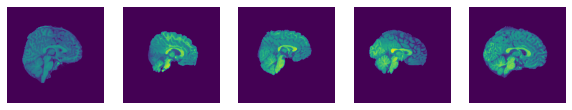

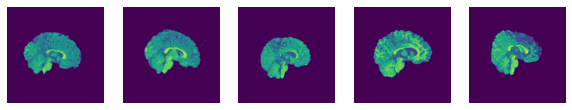

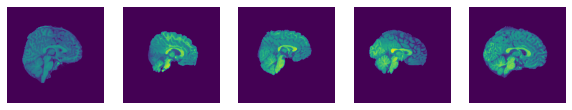

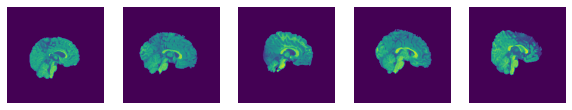

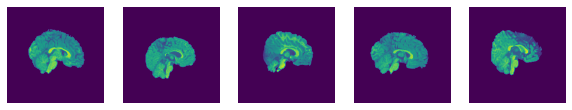

In [21]:
##problem 2 : 

#shard 0, 1st run
show_first_images(build_run_pipe(simple_pipeline(batch_size = 5, num_threads = 4, 
                                           device_id = 0))[0]
            , columns = 5)

#shard 1, 1st run
show_first_images(build_run_pipe(shard_id_change(batch_size = 5, num_threads = 4, 
                                           device_id = 0))[0]
            , columns = 5)

#shard 0, 1st run, differen seed (random off)
show_first_images(build_run_pipe(seed_change(batch_size = 5, num_threads = 4, 
                                           device_id = 0))[0]
            , columns = 5)

#shard 0, 1st run, same seed, (random on)
show_first_images(build_run_pipe(only_random(batch_size = 5, num_threads = 4, 
                                           device_id = 0))[0]
            , columns = 5)


#shard 0, 1st run, differen seed (random on)
show_first_images(build_run_pipe(seed_change_with_random(batch_size = 5, num_threads = 4, 
                                           device_id = 0))[0]
            , columns = 5)

In [ ]:
#stick to shard, last batch 어떻게할지
#

### X.3.1. Single GPU, making DataLoader

In [23]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator

pipe = TrainPipeline(batch_size = 16, num_threads = 4, device_id = 0, 
                     imgs = data_path, **kwargs)
pipe.build()

dali_iter = DALIGenericIterator(pipes, ['data', 'label'], reader_name='Reader')

data_path



flip here enalbes any combinations of three types of flipping, while the original only had one
therefore, ipmlement the original yAware version of flipping too (or not..
in normalizaiton, make sure that even when doing multichannel, channel-wise normalization is not done (only single channel-wise normalization(즉, axis_names = 'DHW'가 잘작동하는지 보기 
also see if dali batch size and gpu batch size have to be the same (즉, 16짜리 dali를 두번돌려서 2*16 = 32W짜리 model batch size에 맞춰도 되나?
DDP + DALI? (data sampler이 DDP스면 rank마다 다르게 주는 걸로 알고있는데, 이거에 맞게 DALI는 어떻게 되는거지?
also crop/cutout patch size could also be made random if needed?


NameError: name 'pipes' is not defined

In [ ]:
import os 
print(os.getenv("LOCAL_RANK", "0"))

In [ ]:
print(os.getenv("LOCAL_RANK"))

In [ ]:
print(simple_images[0].as_array()[0].mean(), simple_images[0].as_array()[0].std())
print(images[0].as_cpu().as_array()[0].mean(), images[0].as_cpu().as_array()[0].std())

### using the most recent thing
(https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/nnUNet/data_loading/data_module.py)

In [ ]:

#from the data modules
import glob
import os

import numpy as np
#from pytorch_lightning import LightningDataModule
from sklearn.model_selection import KFold
#from utils.utils import get_config_file, get_task_code, print0

from dali_loader_newer import fetch_dali_loader



def get_split(data, idx):
    return list(np.array(data)[idx])


def load_data(path, files_pattern, non_empty=True):
    data = sorted(glob.glob(os.path.join(path, files_pattern)))
    if non_empty:
        assert len(data) > 0, f"No data found in {path} with pattern {files_pattern}"
    return data

In [ ]:
#def setup(self, stage=None):
#    """
#    will silence anything that doesn't need to be run (i.e only do imgs and lbls)
#    """
#    meta = load_data(self.data_path, "*_meta.npy")
#    orig_lbl = load_data(self.data_path, "*_orig_lbl.npy")
#    
#    #========modified======
#    #imgs, lbls = load_data(self.data_path, "*_x.npy"), load_data(self.data_path, "*_y.npy")
#    imgs = load_data(self.data_path, "sub-*.npy")
#    lbls = len(imgs)*load_data(os.getcwd(),'test_label.npy')
#    
#    #=======================
#    self.test_imgs, test_meta = get_test_fnames(self.args, self.data_path, meta)
#
#    if self.args.exec_mode != "predict" or self.args.benchmark:
#        train_idx, val_idx = list(self.kfold.split(imgs))[self.args.fold]
#        orig_lbl, meta = get_split(orig_lbl, val_idx), get_split(meta, val_idx)
#        self.kwargs.update({"orig_lbl": orig_lbl, "meta": meta})
#        self.train_imgs, self.train_lbls = get_split(imgs, train_idx), get_split(lbls, train_idx)
#        self.val_imgs, self.val_lbls = get_split(imgs, val_idx), get_split(lbls, val_idx)
#
#        if self.args.gpus > 1:
#            rank = int(os.getenv("LOCAL_RANK", "0"))
#            self.val_imgs = self.val_imgs[rank :: self.args.gpus]
#            self.val_lbls = self.val_lbls[rank :: self.args.gpus]
#    else:
#        self.kwargs.update({"meta": test_meta})
#    print0(f"{len(self.train_imgs)} training, {len(self.val_imgs)} validation, {len(self.test_imgs)} test examples")

def train_dataloader(self):
    return fetch_dali_loader(self.train_imgs, self.train_lbls, self.args.batch_size, "train", **self.kwargs)

def val_dataloader(self):
    return fetch_dali_loader(self.val_imgs, self.val_lbls, 1, "eval", **self.kwargs)

def test_dataloader(self):
    if self.kwargs["benchmark"]:
        return fetch_dali_loader(self.train_imgs, self.train_lbls, self.args.val_batch_size, "test", **self.kwargs)
    return fetch_dali_loader(self.test_imgs, None, 1, "test", **self.kwargs)


In [ ]:
#get_dataloader_fn(data_dir = "/hpcgpfs01/scratch/dyhan316/testing_4_dali", 
#                 batch_size = 32, precision=None)


data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali"

imgs = load_data(data_path, "sub-*.npy")
lbls = len(imgs)*load_data(os.getcwd(),'test_label.npy')


meta = len(imgs)*load_data(os.getcwd(),'test_label.npy')


kwargs = {
    "dim": 3,
    "seed": 0,
    "gpus": 1,
    "nvol": 0,
    "layout": "CDHW", #fn.reshape의 varialbe
    #"overlap": self.args.overlap,
    "benchmark": False,
    "num_workers": 4,
    "oversampling": 0.5, #self.args.oversampling, (argument of fn.segmentation.random_object_bbox)
    #"test_batches": self.args.test_batches,
    #"train_batches": self.args.train_batches,
    #"invert_resampled_y": self.args.invert_resampled_y,
    "patch_size": [128, 128, 128], # get_config_file(self.args)["patch_size"],
    "meta" : meta
}

fetch_dali_loader(imgs, lbls, 32, "test", **kwargs)


#set randomly
#train_idx = 500
#train_imgs, train_lbls = get_split(imgs, train_idx), get_split(lbls, train_idx)

## Using the old way : 



Here : https://github.com/NVIDIA/DeepLearningExamples/blob/905e9e507eec6d83e0b164ce8925523f6d1b1f8c/PyTorch/Segmentation/nnUNet/triton/dataloader.py

https://github.com/NVIDIA/DeepLearningExamples/blob/905e9e507eec6d83e0b164ce8925523f6d1b1f8c/PyTorch/Segmentation/nnUNet/data_loading/dali_loader.py

In [ ]:
import numpy as np
#from data_loading.dali_loader import fetch_dali_loader
from dali_loader_older import fetch_dali_loader#.py로 가져옴
from sklearn.model_selection import KFold
#from utils.utils import get_split, load_data #imported into the code itself 
import glob
import os 


def get_split(data, idx):
    return list(np.array(data)[idx])


def load_data(path, files_pattern):
    return sorted(glob.glob(os.path.join(path, files_pattern)))

def get_dataloader_fn(*, data_dir: str, batch_size: int, precision: str):
    kwargs = {
        "dim": 3,
        "gpus": 1,
        "seed": 0,
        "num_workers": 8,
        "meta": None,
        "oversampling": 0,
        "benchmark": False,
        "patch_size": [128, 128, 128]
    }

    #======modieified=======#
    #imgs, lbls = load_data(data_dir, "*_x.npy"), load_data(data_dir, "*_y.npy")
    imgs = load_data(data_dir, "sub-*.npy")
    lbls = load_data(data_dir, "sub-*.npy")
    #lbls = len(imgs)*load_data(os.getcwd(),'test_label.npy')
    #=======================#
    
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=12345)
    _, val_idx = list(kfold.split(imgs))[2]
    imgs, lbls = get_split(imgs, val_idx), get_split(lbls, val_idx)
    
    import pdb ; pdb.set_trace()
    dataloader = fetch_dali_loader(imgs, lbls, batch_size, "bermuda", **kwargs) #kwargs :이미 지정해준 것이 있다  (맨위에)

    def _dataloader_fn():
        for i, batch in enumerate(dataloader):
            fname = [f"{i}_{j}" for j in range(batch_size)]
            img = batch["image"].numpy()
            if "fp16" in precision:
                img = img.astype(np.half)
            img = {"INPUT__0": img}
            lbl = {"OUTPUT__0": batch["label"].squeeze(1).numpy().astype(int)}
            yield fname, img, lbl

    return _dataloader_fn

In [ ]:
get_dataloader_fn(data_dir = "/hpcgpfs01/scratch/dyhan316/testing_4_dali", 
                 batch_size = 32, precision=None)

아, 이게 
```python
Error when executing CPU operator NumpyReader, instance name: "ReaderY", encountered:
```

`ops.NumpyReader`을 `get_numpy_reader`에서 쓰는데, (BermudaPipeline할때), 그때 BermudatePipeline에서 defin_graph할떄 (probably similar to the `@pipeline_def` we did previously) 
```python
    def define_graph(self):
        img, lbl = self.input_x(name="ReaderX"), self.input_y(name="ReaderY") 
```
여기서, (name = "ReaderY")등등이, 애초에 존재하지 않는 것 같다 (the option to do name is not possible I think
    
    
=> 아니다, name = "hahah"해도 되기는 된다 (maybe just naming stuff)

In [ ]:

#아니면 여기서 직접 돌려보기?
dali_loader.TrainPipeline(batch_size = 32, num_threads = 4, device_id = 0, dim = 3 )

### (부록) : making npy dataset for testing (becasue dali_loader can only load npy files)

In [ ]:
#import nibabel as nib
#import numpy as np 
#import os 
#
#img_dir = "/hpcgpfs01/scratch/dyhan316/CHA_T1_nothing_done"
#save_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali"
#for file in os.listdir(img_dir):
#    img = nib.load(os.path.join(img_dir,file))
#    np_array = np.array(img.dataobj)
#    np.save(f"{save_path}/{file[:-7]}.npy", np_array)   

In [ ]:
import numbers
def interval(obj, lower=None):
    """ Listify an object.
    Parameters
    ----------
    obj: 2-uplet or number
        the object used to build the interval.
    lower: number, default None
        the lower bound of the interval. If not specified, a symetric
        interval is generated.
    Returns
    -------
    interval: 2-uplet
        an interval.
    """
    if isinstance(obj, numbers.Number):
        if obj < 0:
            raise ValueError("Specified interval value must be positive.")
        if lower is None:
            lower = -obj
        return (lower, obj)
    if len(obj) != 2:
        raise ValueError("Interval must be specified with 2 values.")
    min_val, max_val = obj
    if min_val > max_val:
        raise ValueError("Wrong interval boudaries.")
    return tuple(obj)

In [ ]:
sigma = interval((0.1,1),lower = 0)

In [ ]:
sigma

In [201]:
os.getcwd()

'/direct/sdcc+u/dyhan316/VAE_ADHD/NVIDIA_DALI_AUGMENTATION'

In [199]:
a = [(3,3),(4,5)]

In [200]:
for i,j in a:
    print(i,j)

3 3
4 5


In [23]:
import nvidia.dali as dali
import nvidia.dali.fn as fn
import numpy as np


#@dali.pipeline_def(batch_size=3, num_threads=1, device_id=0, prefetch_queue_depth=1)
@dali.pipeline.experimental.pipeline_def(batch_size=3, num_threads=1, device_id=0, prefetch_queue_depth=1, debug = True)
def pipe():
    img = fn.external_source(name="IN").gpu()
    print(img.shape())
    
    img = img[dali.newaxis]
    
    print(img.shape())
    
    img = fn.reshape(img, layout="CDHW")
    print(img.shape())
    img = fn.resize(img, size=(80., 80., 80.))
    print(img.shape())
    
    img_stack = fn.stack(img, img,axis = 0)
    print("after stacking :" ,img_stack.shape())
    return img_stack


p = pipe()
p.build()
#inp = np.random.rand(1, 256, 256, 256).astype(dtype=np.float32)
inp = np.random.rand( 1,256, 256, 256).astype(dtype=np.float32)
p.feed_input("IN", inp)
oo = p.run()
print(oo)
#print(oo)

[(256, 256, 256)]
[(1, 256, 256, 256)]
[(1, 256, 256, 256)]
[(1, 80, 80, 80)]
after stacking : [(2, 1, 80, 80, 80)]
(TensorListGPU(
    [[[[[[0.584816   0.5619479  ... 0.47915703 0.4856381 ]
         [0.60298264 0.5575608  ... 0.47510287 0.5560816 ]
         ...
         [0.45428118 0.50358623 ... 0.51969796 0.49324477]
         [0.4595505  0.45714372 ... 0.4595735  0.49857837]]

        [[0.52680725 0.5366506  ... 0.4827886  0.47709396]
         [0.51911217 0.48870727 ... 0.5009376  0.5264682 ]
         ...
         [0.5567119  0.45797372 ... 0.5592565  0.56578964]
         [0.4861688  0.44019955 ... 0.5268607  0.5542435 ]]

        ...

        [[0.55214745 0.43763903 ... 0.51215506 0.54233456]
         [0.47060505 0.4772633  ... 0.4854141  0.4947739 ]
         ...
         [0.44694737 0.4805726  ... 0.5006794  0.49694416]
         [0.4989615  0.5460764  ... 0.53230387 0.51873064]]

        [[0.50338286 0.49046454 ... 0.5181161  0.5455944 ]
         [0.47291294 0.49320698 ... 0.53981

#### Trying numpy readers with labels

In [4]:
##trying to just do regular stuff
from nvidia.dali.pipeline import Pipeline
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import os 

data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali"

label_list = len(os.listdir(data_path))*[0]


@pipeline_def
def simple_pipeline():

    img = fn.readers.numpy(file_root = data_path, labels = 0)
    #img = fn.reshape(img, layout = "DHW") #CDHW 하면 애러뜸!
    return img #, label #, fn.get_property(img, key = "source_info")


pipe = simple_pipeline(batch_size = 16, num_threads = 1, device_id = 0, seed = 42)
pipe.build()

simple_images, label  = pipe.run()



RuntimeError: [/opt/dali/dali/pipeline/operator/op_schema.cc:753] Assert on "HasArgument(name)" failed: Argument "labels" is not supported by operator "readers__Numpy".
Stacktrace (100 entries):
[frame 0]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali.so(+0xc2d5b) [0x2b1c780c2d5b]
[frame 1]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/libdali.so(dali::OpSchema::GetArgumentType(std::string const&) const+0x350) [0x2b1c78196f00]
[frame 2]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/backend_impl.cpython-38-x86_64-linux-gnu.so(+0xb612c) [0x2b1c9376a12c]
[frame 3]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/site-packages/nvidia/dali/backend_impl.cpython-38-x86_64-linux-gnu.so(+0xb9bcd) [0x2b1c9376dbcd]
[frame 4]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyCFunction_Call+0x56) [0x5573dd4c3c96]
[frame 5]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyObject_MakeTpCall+0x22f) [0x5573dd48031f]
[frame 6]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x18227c) [0x5573dd4d027c]
[frame 7]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb37e) [0x5573dd44937e]
[frame 8]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 9]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb3cc) [0x5573dd4493cc]
[frame 10]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x7df) [0x5573dd4cf13f]
[frame 11]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x1e3) [0x5573dd4cfbf3]
[frame 12]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyObject_FastCallDict+0x24b) [0x5573dd4d077b]
[frame 13]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyObject_Call_Prepend+0x63) [0x5573dd4d09e3]
[frame 14]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x182b7a) [0x5573dd4d0b7a]
[frame 15]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x1320cc) [0x5573dd4800cc]
[frame 16]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyObject_Call+0x70) [0x5573dd47fcc0]
[frame 17]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x22b0) [0x5573dd509770]
[frame 18]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x659) [0x5573dd4cefb9]
[frame 19]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x1e3) [0x5573dd4cfbf3]
[frame 20]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyVectorcall_Call+0x71) [0x5573dd47fb01]
[frame 21]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x22b0) [0x5573dd509770]
[frame 22]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x7df) [0x5573dd4cf13f]
[frame 23]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x1e3) [0x5573dd4cfbf3]
[frame 24]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfa6c1) [0x5573dd4486c1]
[frame 25]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 26]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyVectorcall_Call+0x71) [0x5573dd47fb01]
[frame 27]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x22b0) [0x5573dd509770]
[frame 28]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 29]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb3cc) [0x5573dd4493cc]
[frame 30]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x7df) [0x5573dd4cf13f]
[frame 31]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x1e3) [0x5573dd4cfbf3]
[frame 32]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfa6c1) [0x5573dd4486c1]
[frame 33]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x2d2) [0x5573dd4cec32]
[frame 34]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyEval_EvalCodeEx+0x44) [0x5573dd4cfa04]
[frame 35]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyEval_EvalCode+0x1c) [0x5573dd562f5c]
[frame 36]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x24df33) [0x5573dd59bf33]
[frame 37]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x135359) [0x5573dd483359]
[frame 38]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb3cc) [0x5573dd4493cc]
[frame 39]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyGen_Send+0x149) [0x5573dd4c8ea9]
[frame 40]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x4a8d) [0x5573dd50bf4d]
[frame 41]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyGen_Send+0x149) [0x5573dd4c8ea9]
[frame 42]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x4a8d) [0x5573dd50bf4d]
[frame 43]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyGen_Send+0x149) [0x5573dd4c8ea9]
[frame 44]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x163b2d) [0x5573dd4b1b2d]
[frame 45]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb35d) [0x5573dd44935d]
[frame 46]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 47]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb3cc) [0x5573dd4493cc]
[frame 48]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 49]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb35d) [0x5573dd44935d]
[frame 50]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x2d2) [0x5573dd4cec32]
[frame 51]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x1e3) [0x5573dd4cfbf3]
[frame 52]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x182119) [0x5573dd4d0119]
[frame 53]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyVectorcall_Call+0x71) [0x5573dd47fb01]
[frame 54]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x22b0) [0x5573dd509770]
[frame 55]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x659) [0x5573dd4cefb9]
[frame 56]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x181fd0) [0x5573dd4cffd0]
[frame 57]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfa6c1) [0x5573dd4486c1]
[frame 58]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyGen_Send+0x149) [0x5573dd4c8ea9]
[frame 59]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x4a8d) [0x5573dd50bf4d]
[frame 60]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyGen_Send+0x149) [0x5573dd4c8ea9]
[frame 61]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x4a8d) [0x5573dd50bf4d]
[frame 62]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyGen_Send+0x149) [0x5573dd4c8ea9]
[frame 63]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x4a8d) [0x5573dd50bf4d]
[frame 64]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyGen_Send+0x149) [0x5573dd4c8ea9]
[frame 65]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x4a8d) [0x5573dd50bf4d]
[frame 66]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyGen_Send+0x149) [0x5573dd4c8ea9]
[frame 67]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/lib-dynload/_asyncio.cpython-38-x86_64-linux-gnu.so(+0x6e82) [0x2b1c4fb1de82]
[frame 68]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/lib/python3.8/lib-dynload/_asyncio.cpython-38-x86_64-linux-gnu.so(+0x76bd) [0x2b1c4fb1e6bd]
[frame 69]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyObject_MakeTpCall+0x22f) [0x5573dd48031f]
[frame 70]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x886ed) [0x5573dd3d66ed]
[frame 71]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x135680) [0x5573dd483680]
[frame 72]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyVectorcall_Call+0x71) [0x5573dd47fb01]
[frame 73]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalFrameDefault+0x54ce) [0x5573dd50c98e]
[frame 74]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 75]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb35d) [0x5573dd44935d]
[frame 76]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 77]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb35d) [0x5573dd44935d]
[frame 78]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 79]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb35d) [0x5573dd44935d]
[frame 80]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 81]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb35d) [0x5573dd44935d]
[frame 82]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x10b) [0x5573dd4cfb1b]
[frame 83]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb35d) [0x5573dd44935d]
[frame 84]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x2d2) [0x5573dd4cec32]
[frame 85]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x181fd0) [0x5573dd4cffd0]
[frame 86]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb37e) [0x5573dd44937e]
[frame 87]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x2d2) [0x5573dd4cec32]
[frame 88]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyEval_EvalCodeEx+0x44) [0x5573dd4cfa04]
[frame 89]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyEval_EvalCode+0x1c) [0x5573dd562f5c]
[frame 90]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x24df33) [0x5573dd59bf33]
[frame 91]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x135359) [0x5573dd483359]
[frame 92]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb3cc) [0x5573dd4493cc]
[frame 93]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x2d2) [0x5573dd4cec32]
[frame 94]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x1e3) [0x5573dd4cfbf3]
[frame 95]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0xfb3cc) [0x5573dd4493cc]
[frame 96]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyEval_EvalCodeWithName+0x2d2) [0x5573dd4cec32]
[frame 97]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(_PyFunction_Vectorcall+0x1e3) [0x5573dd4cfbf3]
[frame 98]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(PyVectorcall_Call+0x71) [0x5573dd47fb01]
[frame 99]: /sdcc/u/dyhan316/.conda/envs/VAE_3DCNN_older_MONAI/bin/python(+0x24abf6) [0x5573dd598bf6]


In [22]:
simple_images[0].source_info()

'./sub-100342.npy'

In [46]:
##trying to just do regular stuff
from nvidia.dali.pipeline import Pipeline
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

import os 

from glob import glob 
data_path = "/hpcgpfs01/scratch/dyhan316/testing_4_dali"
#data_path = "/hpcgpfs01/scratch/dyhan316/ABCD_T1_cropped/2.sMRI_freesurfer_8unit"


data_dir_list = glob(data_path+ "/*.npy")

@pipeline_def
def simple_pipeline():
    img = fn.readers.numpy(files = data_dir_list, device = 'cpu')
                          #cache_header_information=True)
    #labels = fn.get_property(img, key = "source_info")
    #labels = img.source_info()#[img_i.source_info() for img_i in img ]
    return img, fn.get_property(img, key = "source_info")

pipe = simple_pipeline(batch_size = 4, num_threads = 1, device_id = 0, seed = 42)
pipe.build()

img, labels  = pipe.run()

In [47]:
img[0].source_info()

'/hpcgpfs01/scratch/dyhan316/testing_4_dali/sub-101743.npy'

AttributeError: 'nvidia.dali.backend_impl.TensorListCPU' object has no attribute 'source_info'

/bin/bash: conda: command not found
